# Introduction

### Authors: Hariganesh Srinivasan, Saicharan Balamurali, Abdouh Harouna Kenfack, Eric Han

Neurodegenerative diseases such as Alzheimer's and brain tumors, are a leading cause of death and disability across the globe. However, it is hard to quantify how well these deadly disorders respond to treatment. Instead, if there was a technique by which images of these cells could be passed to a network which could effectively predict and segment the exact position of these cells on the image, further medical escalation could become much easier. As students of Machine Learning, we see this problem as a great opportunity to exercise our knowledge to find a solution to a noble cause. This problem is important because of the societal impact it has on the healthcare industry. In terms of technical motivation,our team is inspired by such a task because of our interest in contemporary computer vision challenges. 

Specifically, our project is an instance segmentation problem wherein we are expected to predict the type of neuronal cell in a particular image and generate instance masks for these cells on the image. Current highly ranked models have highly limited mAP (< 0.3) with the available dataset and are time-intensive. The inputs to our algorithm are images of resolution 704 x 520 and the outputs are a cell type class and the annotations of those cells on the image. Our architecture is based off of the Mask-R-CNN architecture which we have used via the detectron libraries. At the start of the project, we set targets of effective data augmentation, K-fold validation and finishing in the top 30% of the leaderboard and we believe we have successfully achieved that. In this notebook, we aim to describe how we went about this project by visualizing the dataset, conducting Exploratory Data Analysis, and showcasing the results of our models.

# Dataset

As a part of the Sartorius Cell Instance Segmentation competition, we had access to 606 training images. The ground truth labels of this data gave us the cell class and the cell masks for each image. The cell masks are given to us as run-length encoded strings. We used these images and the ground truth labels to create models for inference. The resolution of each image is 704 x 520.

In [1]:
!pip install pycocotools

     |████████████████████████████████| 106 kB 4.4 MB/s            
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pycocotools: filename=pycocotools-2.0.3-cp37-cp37m-linux_x86_64.whl size=369815 sha256=278f9849a70113485d0ee626e909045beda78902deb84e4480d331cbafefe556
  Stored in directory: /root/.cache/pip/wheels/a2/09/4f/27f24df9927973a2dd820c3fb741c49d1208b25eb5331181c5
Successfully built pycocotools


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-xwgzfzrk
  Running command git clone --filter=blob:none -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-xwgzfzrk
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9176db667837c57e7118d92a90f887565bd6d4c1
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 49 kB 2.3 MB/s             
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 74 kB 3.2 MB/s             
     |████████████████████████████████| 145 kB 38.4 MB/s            
     |████████████████████████████████| 130 kB 69.4 MB/s            
     |████████████████████████████████| 112 kB 34.8 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=6559790 sha256=45efc50d33ae953f4be304a93249e90eaab828f637b047af37e90acedf932c9a
  Stored in dir

In [3]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from pycocotools.coco import COCO
import skimage.io as io
from PIL import Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.logger import setup_logger
from detectron2.evaluation.evaluator import DatasetEvaluator

from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer
from fastcore.all import *
import torch

import warnings

import IPython
from IPython.display import display

warnings.filterwarnings("ignore")
setup_logger()

<_Logger detectron2 (DEBUG)>

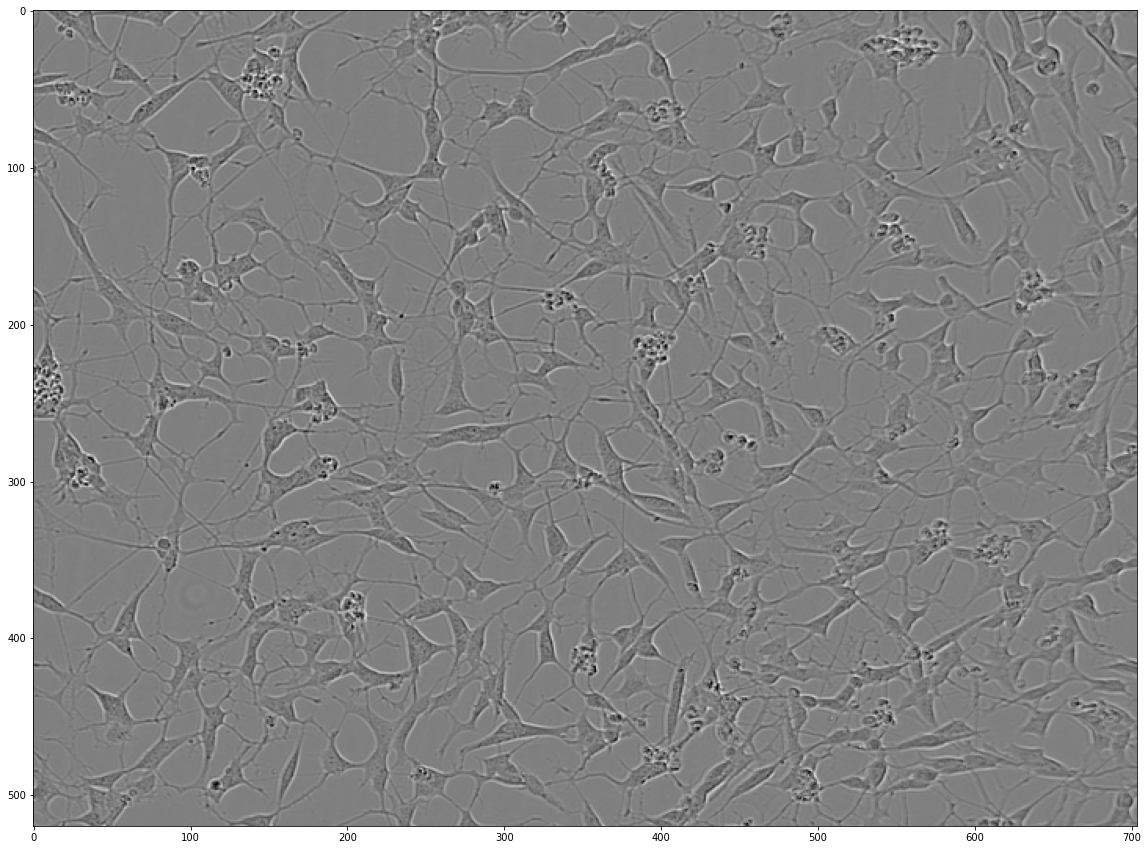

In [4]:
plt.figure(figsize = (20,15))
plt.imshow(cv2.imread(f'../input/sartorius-cell-instance-segmentation/train/0030fd0e6378.png'))

In addition to these training images, we had access to 1972 semi-supervised images. This data was labelled with the cell class but lacked information regarding the cell masks within each image. We used this data to build a classification model which will be expanded upon in the Methods section of this notebook.



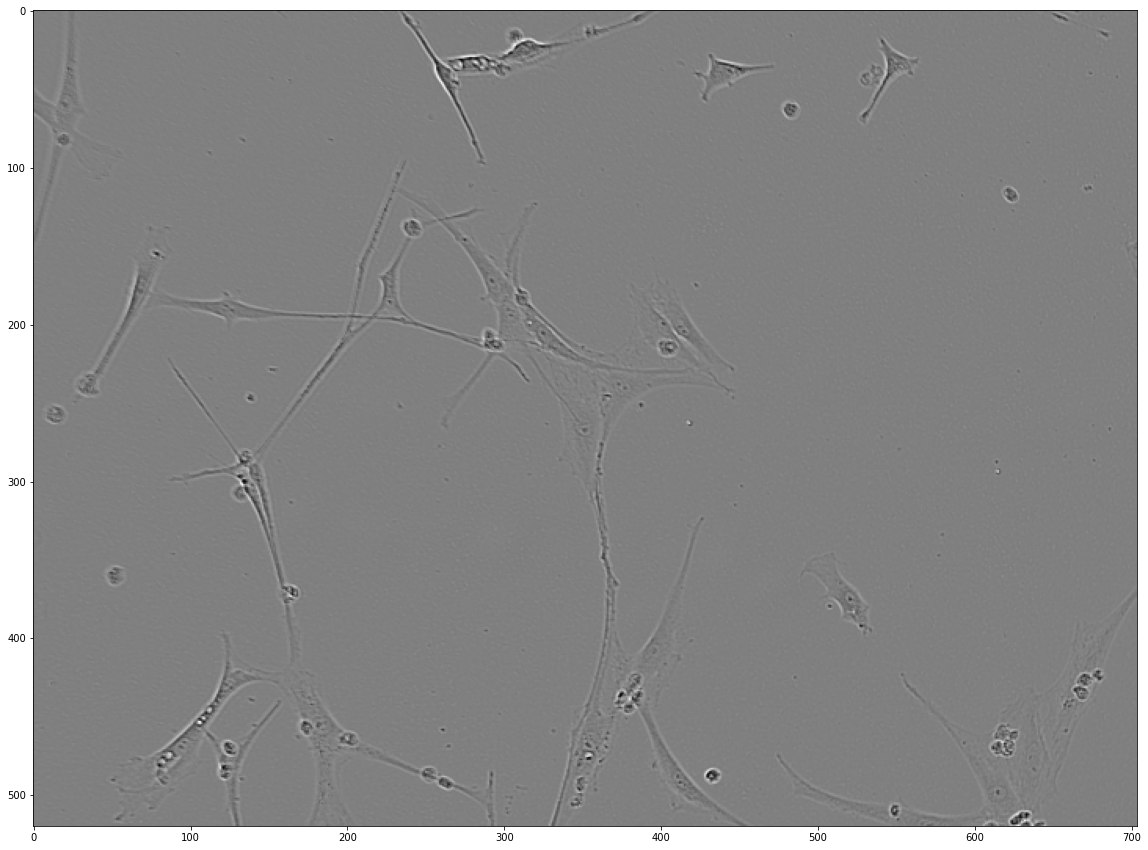

In [5]:
plt.figure(figsize = (20,15))
plt.imshow(cv2.imread(f'../input/sartorius-cell-instance-segmentation/train_semi_supervised/astro[hippo]_D1-1_Vessel-361_2020-09-14_13h00m00s_Ph_1.png'))

Before submission of our model, we have access to 3 test images. Upon submission, our model is scored against the predictions on 240 test images in total which we do not have explicit access to.

# Exploratory Data Analysis

In this section, we study the data available to us in further depth and elaborate on the possible opportunities/challenges that this dataset could pose to us. We start off by reading the 'train.csv' file available to us detailing the annotations for each cell and describing the cell type to us.

In [6]:
df_train = pd.read_csv("../input/sartorius-cell-instance-segmentation/train.csv")
df_train.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0030fd0e6378  189036 1 189739 3 190441 6 191144 7 191848 8 1...    704   
2  0030fd0e6378  173567 3 174270 5 174974 5 175678 6 176382 7 1...    704   
3  0030fd0e6378  196723 4 197427 6 198130 7 198834 8 199538 8 2...    704   
4  0030fd0e6378  167818 3 168522 5 169225 7 169928 8 170632 9 1...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520    shsy5y  11h30m00s  2019-06-16   
2     520    shsy5y  11h30m00s  2019-06-16   
3     520    shsy5y  11h30m00s  2019-06-16   
4     520    shsy5y  11h30m00s  2019-06-16   

                            sample_id elapsed_timedelta  
0  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
2  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
3  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
4  shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00

In the given data, images are classified based on the type of neuronal cell present in that image which are of 3 types - astro, cort, shsy5y.

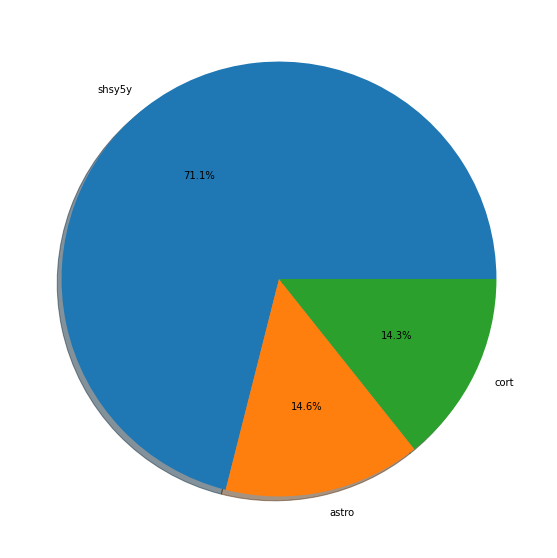

In [7]:
labels = df_train.cell_type.unique()
sizes = df_train.cell_type.value_counts().to_numpy()
plt.figure(figsize = (10,10))
plt.pie(sizes,labels=labels,autopct='%1.1f%%',shadow=True)
plt.show()

Further, it can be shown that each image contains only a single class of neuronal cells. 

In [8]:
dataDir=Path('../input/sartorius-cell-instance-segmentation/')

In [9]:
register_coco_instances('train_sartorius2',{}, '../input/livecellcoco/train_fold_1.json', dataDir)
register_coco_instances('val_sartorius2',{},'../input/livecellcoco/val_fold_1.json', dataDir)
metadata = MetadataCatalog.get('train_sartorius2')
train_ds = DatasetCatalog.get('train_sartorius2')

[12/15 01:35:21 d2.data.datasets.coco]: Loading ../input/livecellcoco/train_fold_1.json takes 1.85 seconds.
[12/15 01:35:21 d2.data.datasets.coco]: Loaded 484 images in COCO format from ../input/livecellcoco/train_fold_1.json


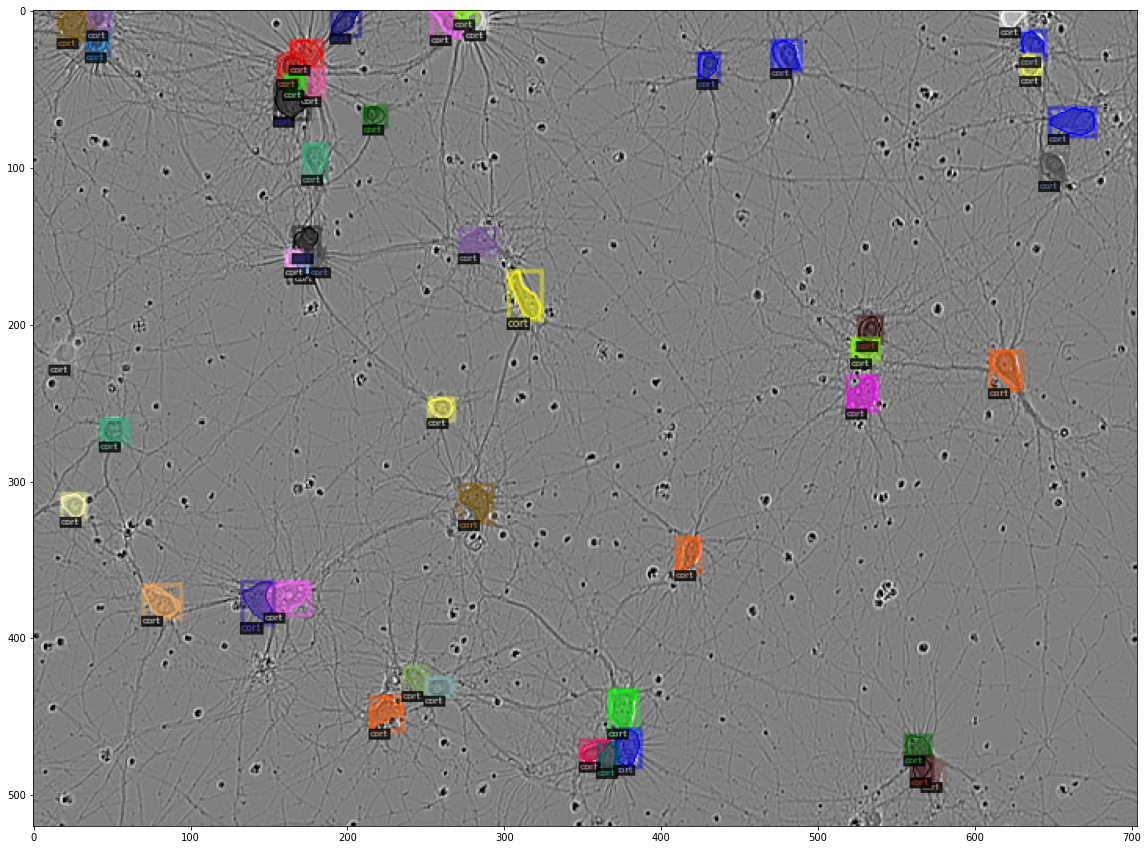

In [10]:
d = train_ds[43]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

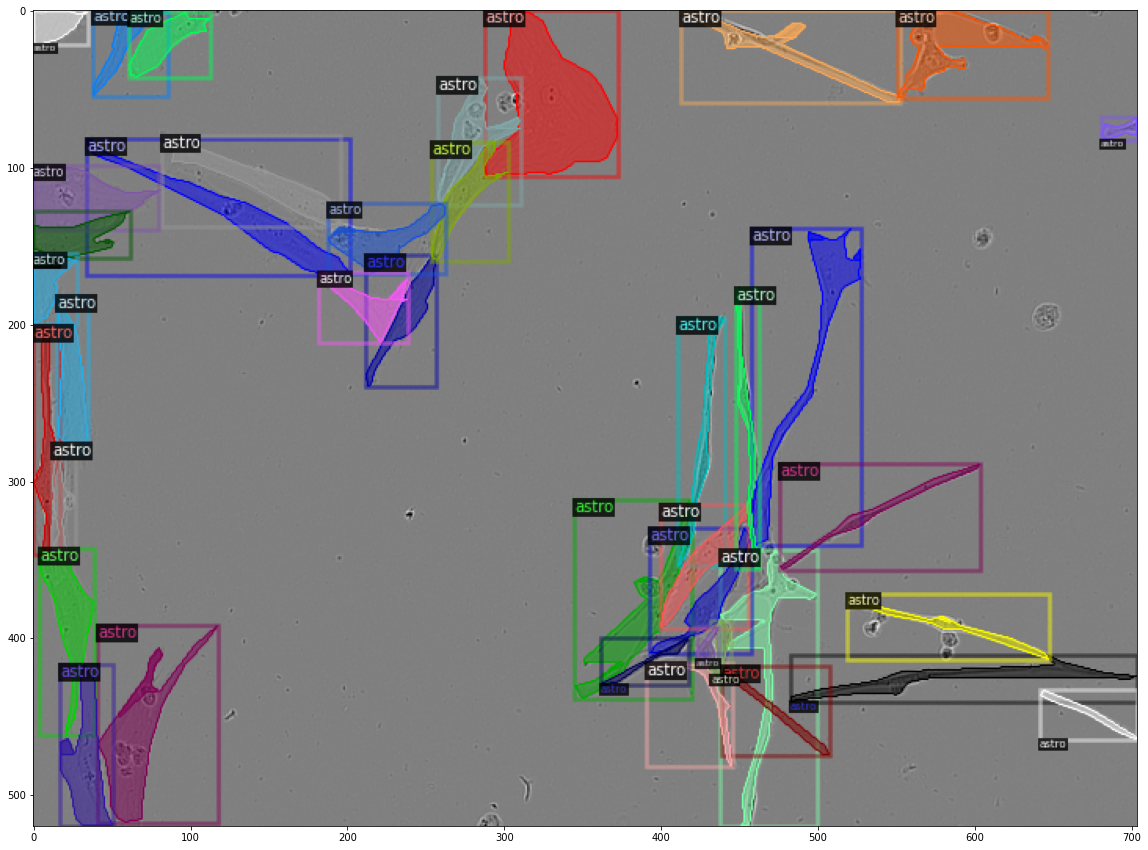

In [11]:
d1 = train_ds[42]
img = cv2.imread(d1["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d1)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

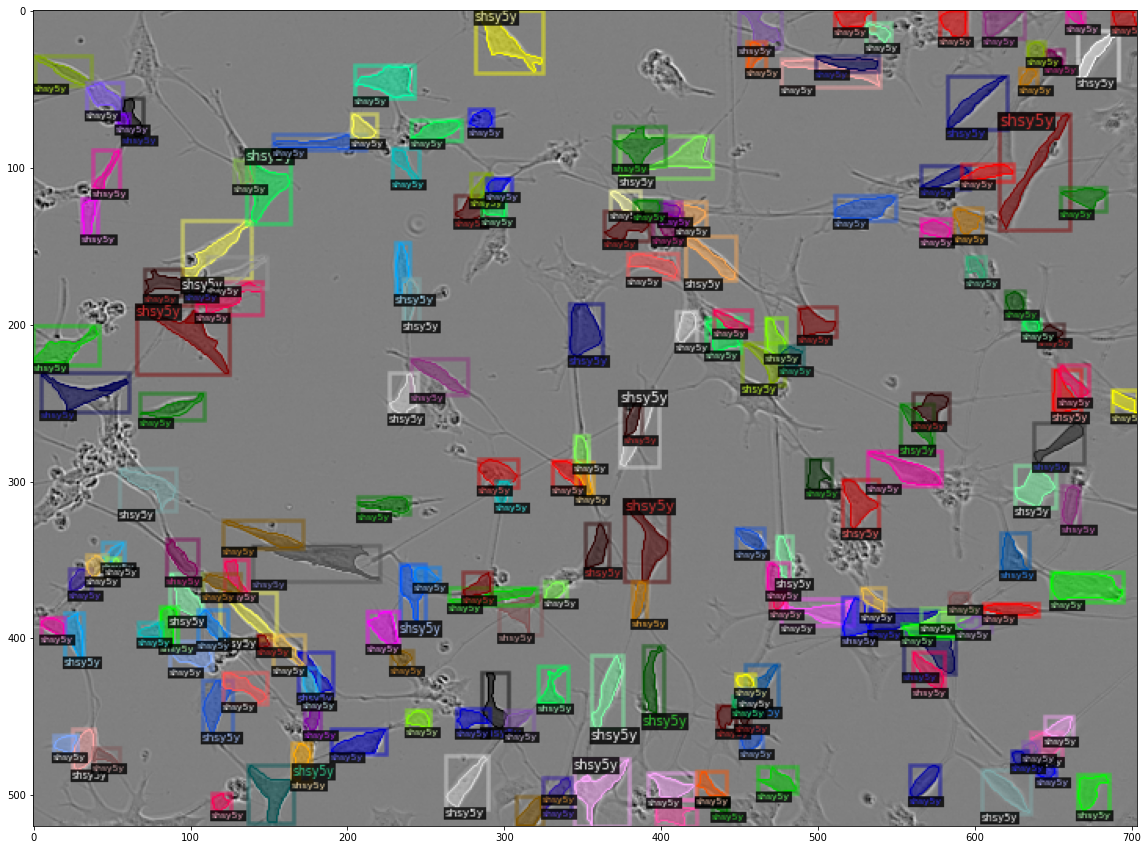

In [12]:
d2 = train_ds[53]
img = cv2.imread(d2["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=metadata)
out = visualizer.draw_dataset_dict(d2)
plt.figure(figsize = (20,15))
plt.imshow(out.get_image()[:, :, ::-1])

The above images show that any randomly selected image has cells of the same class. There can be, however, multiple different masks of the same cell type within a particular image. This will be shown in the next few code blocks.

In [13]:
model_weights_path = Path('../input/livecellweights')
single_model_weights = 'model_best_fold_1.pth'
cell_type_model_weights = {'astro' : 'model_best_astro.pth', 'cort' : 'model_best_cort.pth', 'shsy5y' : 'model_best_shsy5y.pth'}

THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]
CLASS_INDICES = ['astro', 'cort', 'shsy5y']

USE_SINGLE_MODEL = True

In [14]:
#UTILS FUNCTIONS
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_model(weights = 'imagenet'):
    '''
    weights: None for random initialization, 'imagenet' to use imagenet weights
    Returns: keras model which classifies image into cell_type
    '''
    resnet50 = tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        weights= weights,
        input_shape=(704, 520, 3),
        pooling='avg'
    )

    fc1 = tf.keras.layers.Dense(128, activation='relu', name="Dense1")(resnet50.output)
    fc2 = tf.keras.layers.Dense(3, name="Dense2")(fc1)

    model = tf.keras.models.Model(inputs=resnet50.input, outputs=fc2)
    model.load_weights(str(model_weights_path / 'model_checkpoint'))
    return model

def get_masks(image_path, predictor):
    '''
    image_path: Path object containing image path
    predictor: detectron predictor object
    Returns: cleaned masks from the predictor
    '''
    image = cv2.imread(str(image_path))
    pred = predictor(image)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    score_thresh_mask = pred['instances'].scores >= THRESHOLDS[pred_class] # using different threshold per class
    pred_masks = pred['instances'].pred_masks[score_thresh_mask]
    pred_masks = pred_masks.cpu().numpy()
    
    return clean_masks(pred_masks, pred_class)

def classifier_pred(img_path):
    '''
    image_path: Path object containing image path
    Returns: the class corresponding to the image
    '''
    img = cv2.imread(str(img_path))
    img = tf.keras.applications.resnet50.preprocess_input(img)
    img = np.expand_dims(img,0)
    img = np.swapaxes(img,1,2)
    model = get_model(weights = None)
    preds = model.predict(img)
    preds_exp = np.exp(preds - preds.max())
    del model
    return (preds_exp/preds_exp.sum()).argmax()
    
def pred_segmentation_model(model_weights, image_path, num_classes = 1):
    '''
    model_weights: name of networks weights
    image_path: Path object pointing to inference image
    num_classes: number of classes of predictor
    Returns: masks and class of the image
    '''
    predictor =  get_segmentation_model(model_weights, num_classes)
    im = cv2.imread(str(image_path))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class] # using different threshold per class
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    return pred_masks, pred_class

def get_masks_cell_type(image_path, cell_class):
    '''
    image_path: Path object pointing to the inference image
    cell_class: class corresponding to the image
    Returns: cleaned masks of the cell's segementation model
    '''
    
    im = cv2.imread(str(image_path))
    pred_masks, pred_class = pred_segmentation_model(cell_type_model_weights[cell_class, image_path], 1)
    
    return clean_masks(pred_masks, pred_class)
                                                                             
def get_segmentation_model(model_weights, num_classes=1):
    '''
    model_weights: name of model_weights file
    num_classes: number of classes of the predictor
    Returns: segmentation model with loaded weights
    '''
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.INPUT.MASK_FORMAT='bitmask'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes 
    cfg.MODEL.WEIGHTS = str(model_weights_path / model_weights)
    cfg.TEST.DETECTIONS_PER_IMAGE = 1000
    
    return DefaultPredictor(cfg)

def clean_masks(masks, _class):
    '''
    masks: list of numpy array masks
    _class: the class of the masks
    Returns: cleaned masks without overlap and noisy masks
    '''
    res = []
    used = np.zeros_like(masks[0], dtype=int) 
    for mask in masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res

def plot_masks(image_id, colors=True):
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()

    if colors:
        mask = np.zeros((520, 704))
        for label in labels:
            #mask += rle_decode(label, shape=(520, 704, 3), color=np.random.rand(3))
            mask += rle_decode(label)
    else:
        mask = np.zeros((520, 704, 1))
        for label in labels:
            mask += rle_decode(label, shape=(520, 704, 1))
    mask = mask.clip(0, 1)

    image = cv2.imread(f"../input/sartorius-cell-instance-segmentation/train/{image_id}.png")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(16, 32))
    plt.subplot(3, 1, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.subplot(3, 1, 2)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)
    plt.axis("off")
    plt.subplot(3, 1, 3)
    plt.imshow(mask)
    plt.axis("off")
    
    plt.show();

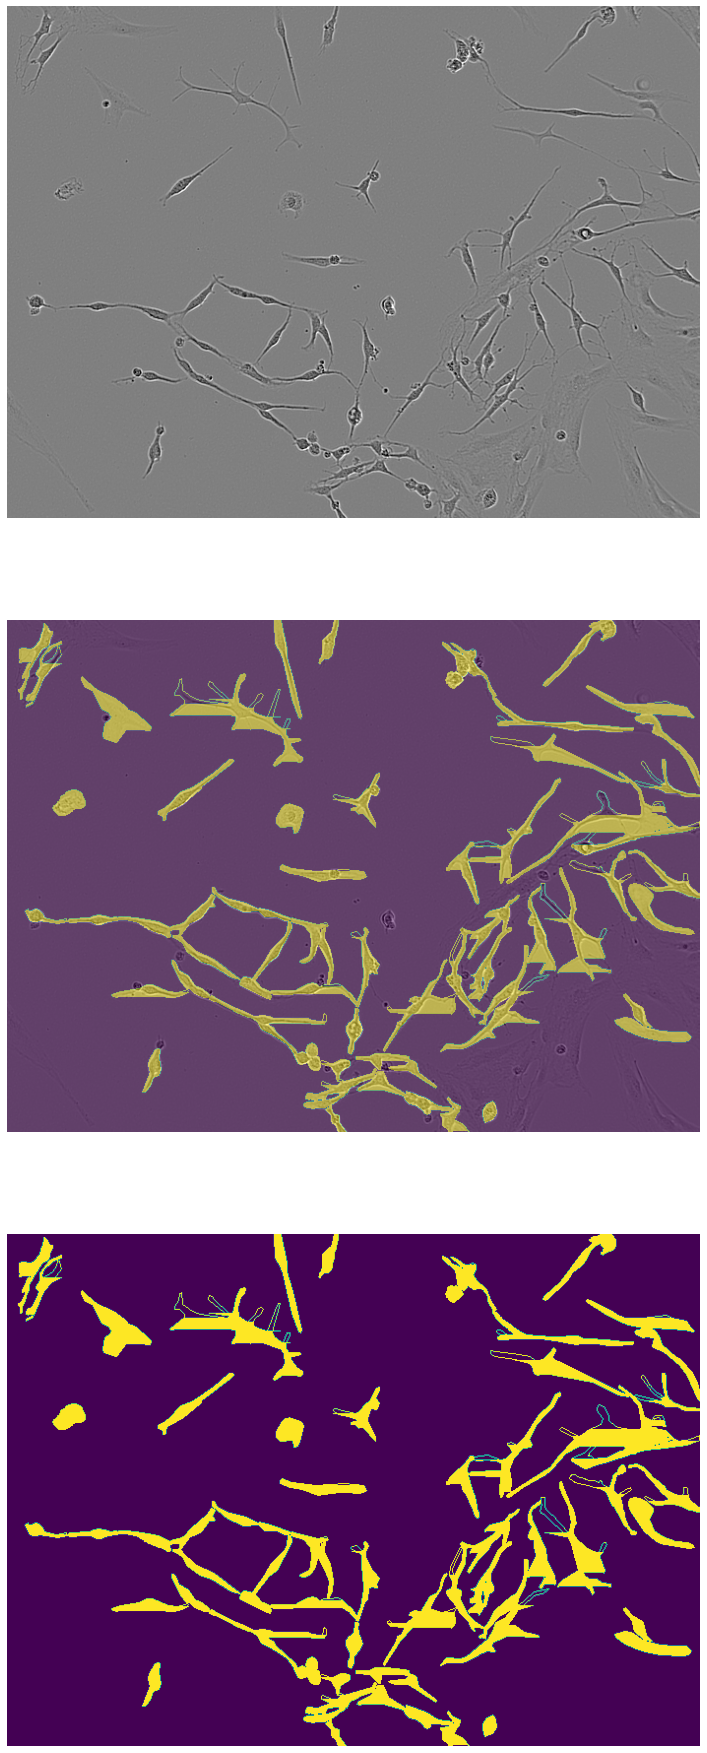

In [15]:
plot_masks("13325f865bb0", colors=True)

For some cells, however, the masks appear to be broken as evident in the last image. This points towards the fact that the dataset received is inherently noisy. Fixing these masks and predicting using the fixed masks is not advisable as the test dataset is labelled with such masks which would result in a low accuracy. The only good way to approach this is to proceed with the broken masks as the ground truth and make predictions based on this data.

# Methods

In [16]:
import IPython
from IPython.display import display

We used Detectron libraries as the base framework of our model. Detectron allows us to use Mask-R-CNN's architecture in order to generate predictions for our task. 

1. Using detectron, we started off by simply splitting our data into an 80-20 train-test split and judging how well our model does. We obtained average results with this method.
2. The next thing we attempted was to split the dataset 5-fold and apply an ensembling technique called non max suppression in order to improve our bounding box predictions slightly. We were successful with this implementation as we obtained a higher mAP score of 0.295.
3. The final method we used in our project was to first run a classification algorithm that determines what kind of cell (i.e. astro/cort/shsy5y) is present in a particular image and then defined a separate segmentation model for each cell class individually.

### Train-Test Split
We used a 80-20 train-test split to split the data into training and testing sets. The split was done per class (i.e astro, shsy5y, cort) to ensure equal propotion of each class in both train and test set. We ran the following command to generate our 80-20 train-test split.
```
train_images, val_images, train_class, val_class = train_test_split(images, image_class, stratify=image_class, test_size=0.2,random_state=17, shuffle=True)
```

### K-fold cross validation and Ensemble NMS
Since we have limited amount of data for training and some noisy data the astro cells, we decided to use 5-fold cross-validation technique to maximize the performance of our model on the given training data. We also noticed that different train-test splits gave different results of MAP implying that our model was very sesensitive to the type of train-test. To avoid eroneous or inconsistent results due to this sensitivity, we did the 5-fold cross validation and averaged the outputs by ensembling each resulting model using Non-max supression technique. Non maximum supression is a technique used to filter out a single entity (bounding box) over many overlapping entities generated by the clasifier using criterias such as probability or IOU. This helps output the best possible combination of each k-fold validation and thus an optimal model.

The flow chart below is a explains the process described above.

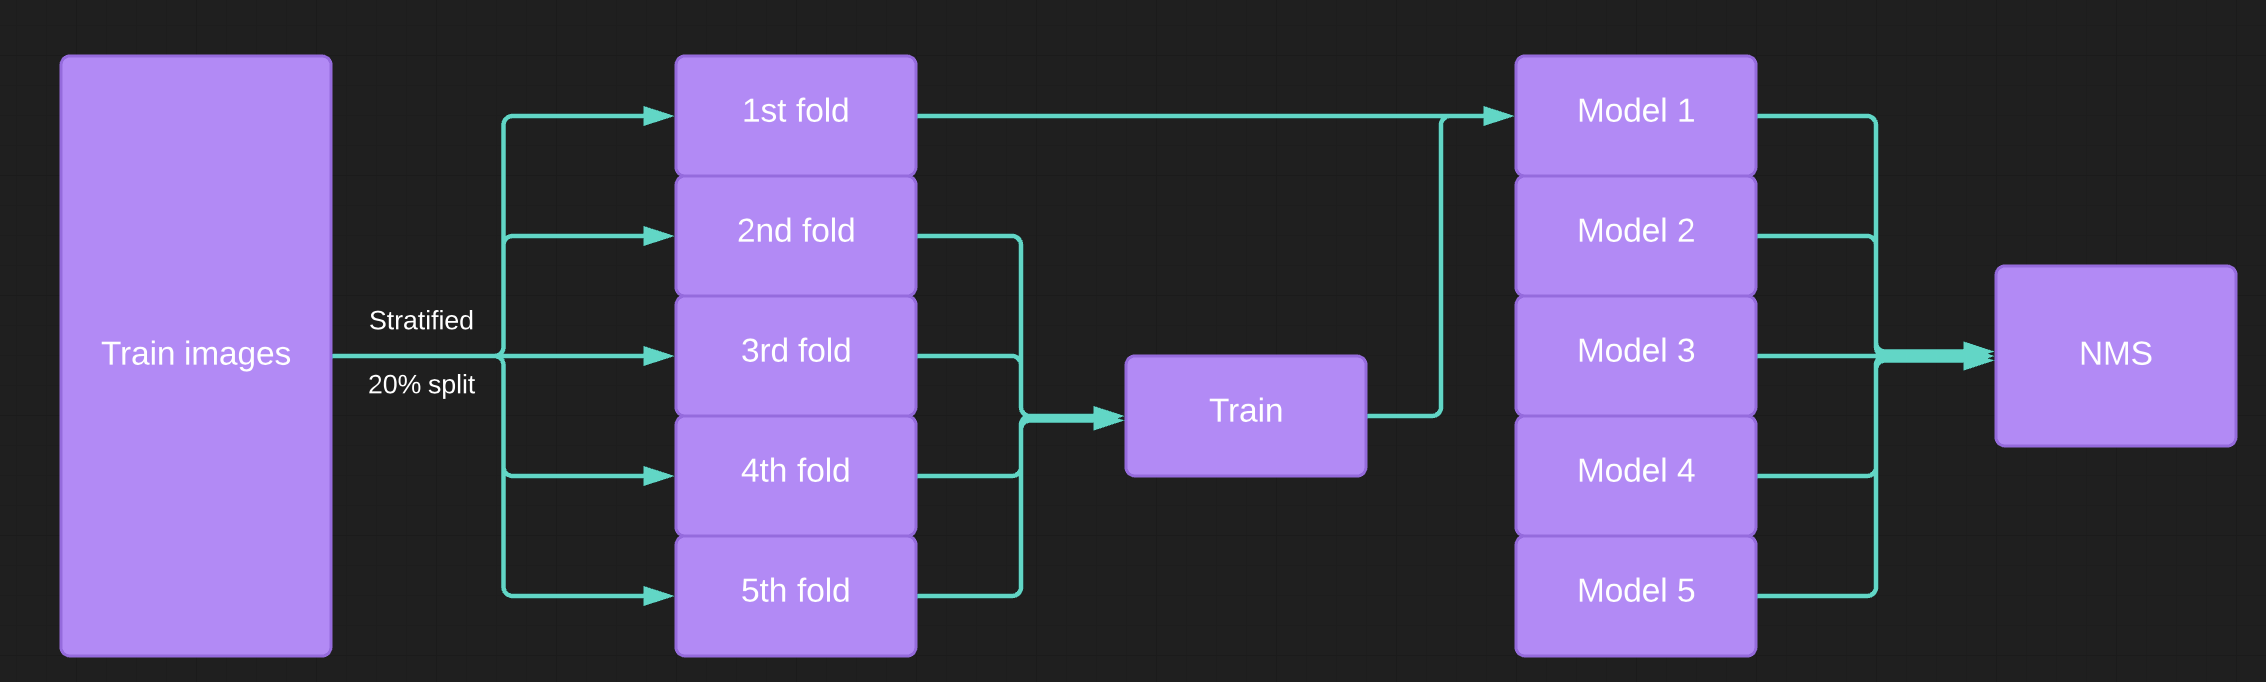

In [17]:
IPython.display.Image(filename = '../input/imgdataset/NMS1.png') 

### Cell-based Classifier
The goal of the cell-based clasifier was to detect the types of cells present in each image. This was possible since each image only has a single cell type (astro, cort or shysy5y) as observed from EDA. To achieve this classification, we used weights from the imagenet challenge and the prebuilt model, resnet50. We obtained a validation accuracy of 99.7% for the image clasification and then passed each classified image to its corresponding segmentation model as shown in the figure below.

Reference the classifier notebook to see this implementation.

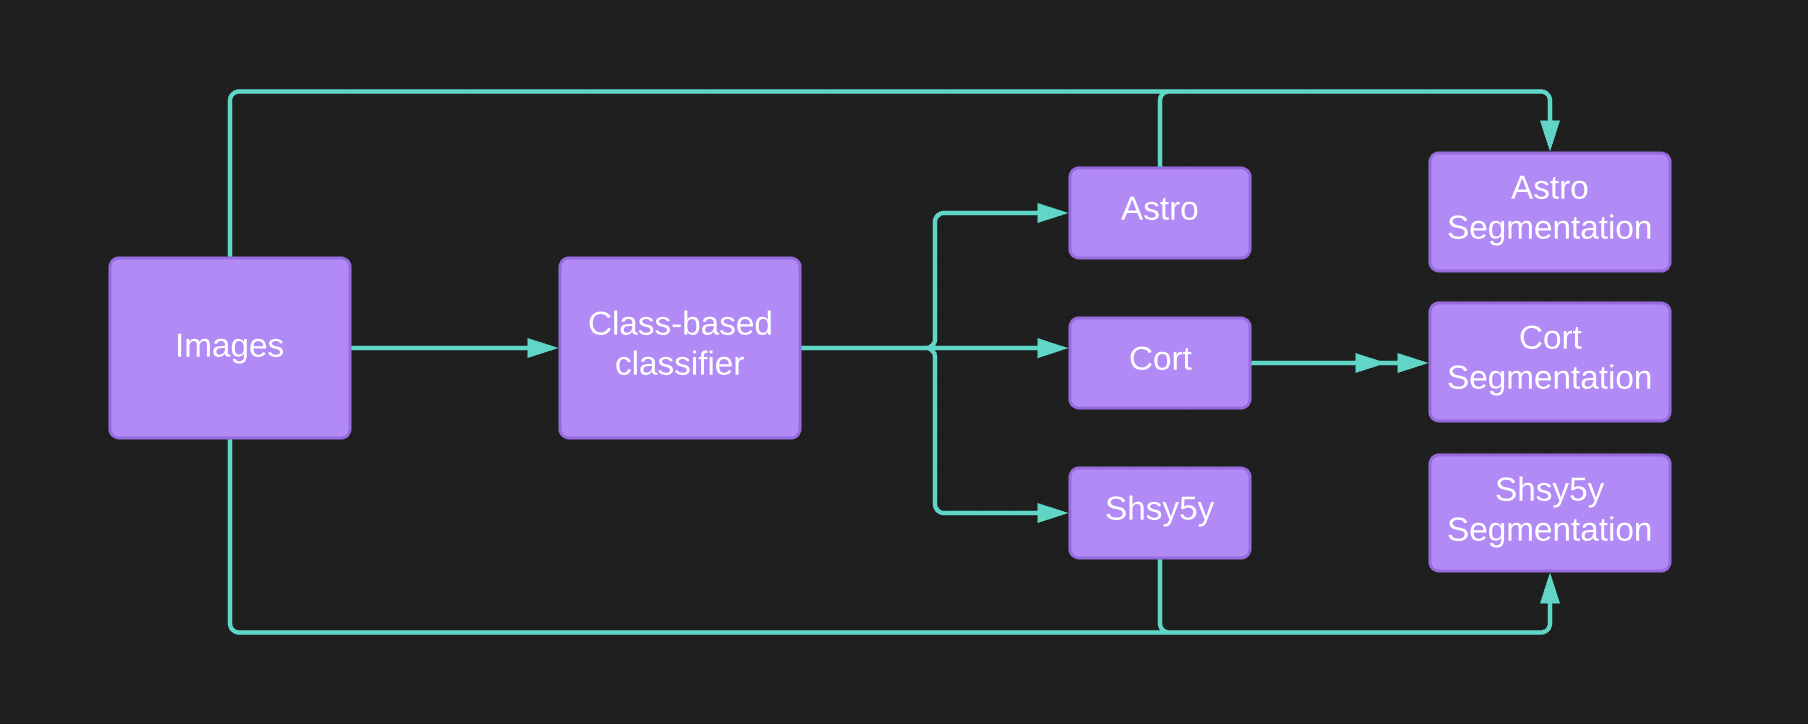

In [18]:
IPython.display.Image(filename = '../input/imgdataset/classifier1.png')

### List of Individual Notebooks:

Apart from this writeup notebook, we have separate notebooks that perform the following functions as follows:

1. K-fold and class-wise data generation notebook
2. Training notebook for individual detectron models
3. Training notebook for classifier
4. Inference notebook for corresponding model
5. Ensembled NMS application notebook

# Post-processing

Transfer Learning was not possible due to a lack of resources (not enough memory) : One obstacle we faced.

As a part of Mask-R-CNN's output, we get confidence scores associated with each object. Based on these confidence scores, it is possible to determine a threshold below which mask predictions for that object will not be submitted. The tradeoff in such a scenario is that we obtain a large number of false negatives (i.e. lack of a mask where there actually is one) if our threshold is high and a large number of false positives (i.e. presence of a mask where there actually isn't one) if our threshold is too low. The graph below shows how accuracy changes with regards to the set threshold. 


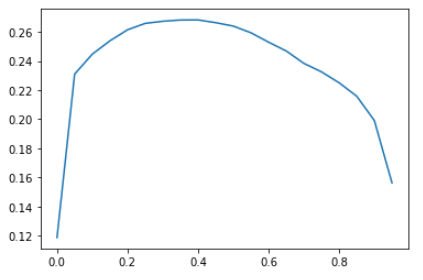

In [19]:
IPython.display.Image(filename = '../input/imgdataset/threshold_total.png')

**x-axis: Set Threshold**

**y-axis: Score (mAP)**

However, upon plotting separate curves for the 3 separate classes, it was found that the three different types of neuronal cells have different optima. This shows that creating three separate threshold levels for each class is a more sensible way to solve this problem.

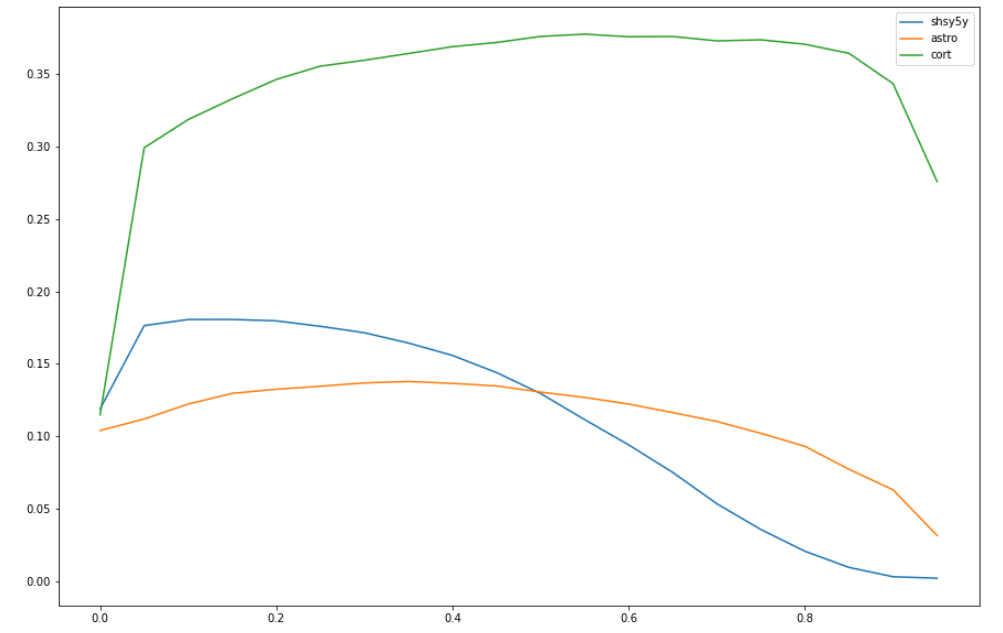

In [20]:
IPython.display.Image(filename = '../input/imgdataset/threshold_byclass.png')

**x-axis: Set Threshold**

**y-axis: Score (mAP)**

Further, the competition requires that submitted masks cannot overlap with each other. Hence, as an additional post-processing step, we ensure that overlapping masks are resolved. This step is shown in our inference notebook. Also, masks below a certain minimum number of pixels threshold are discarded.

# Results

The results of our inference can be shown by highlighting the predicted masks within each image which is shown below:

In [21]:
test_file_names = (dataDir/'test').ls()

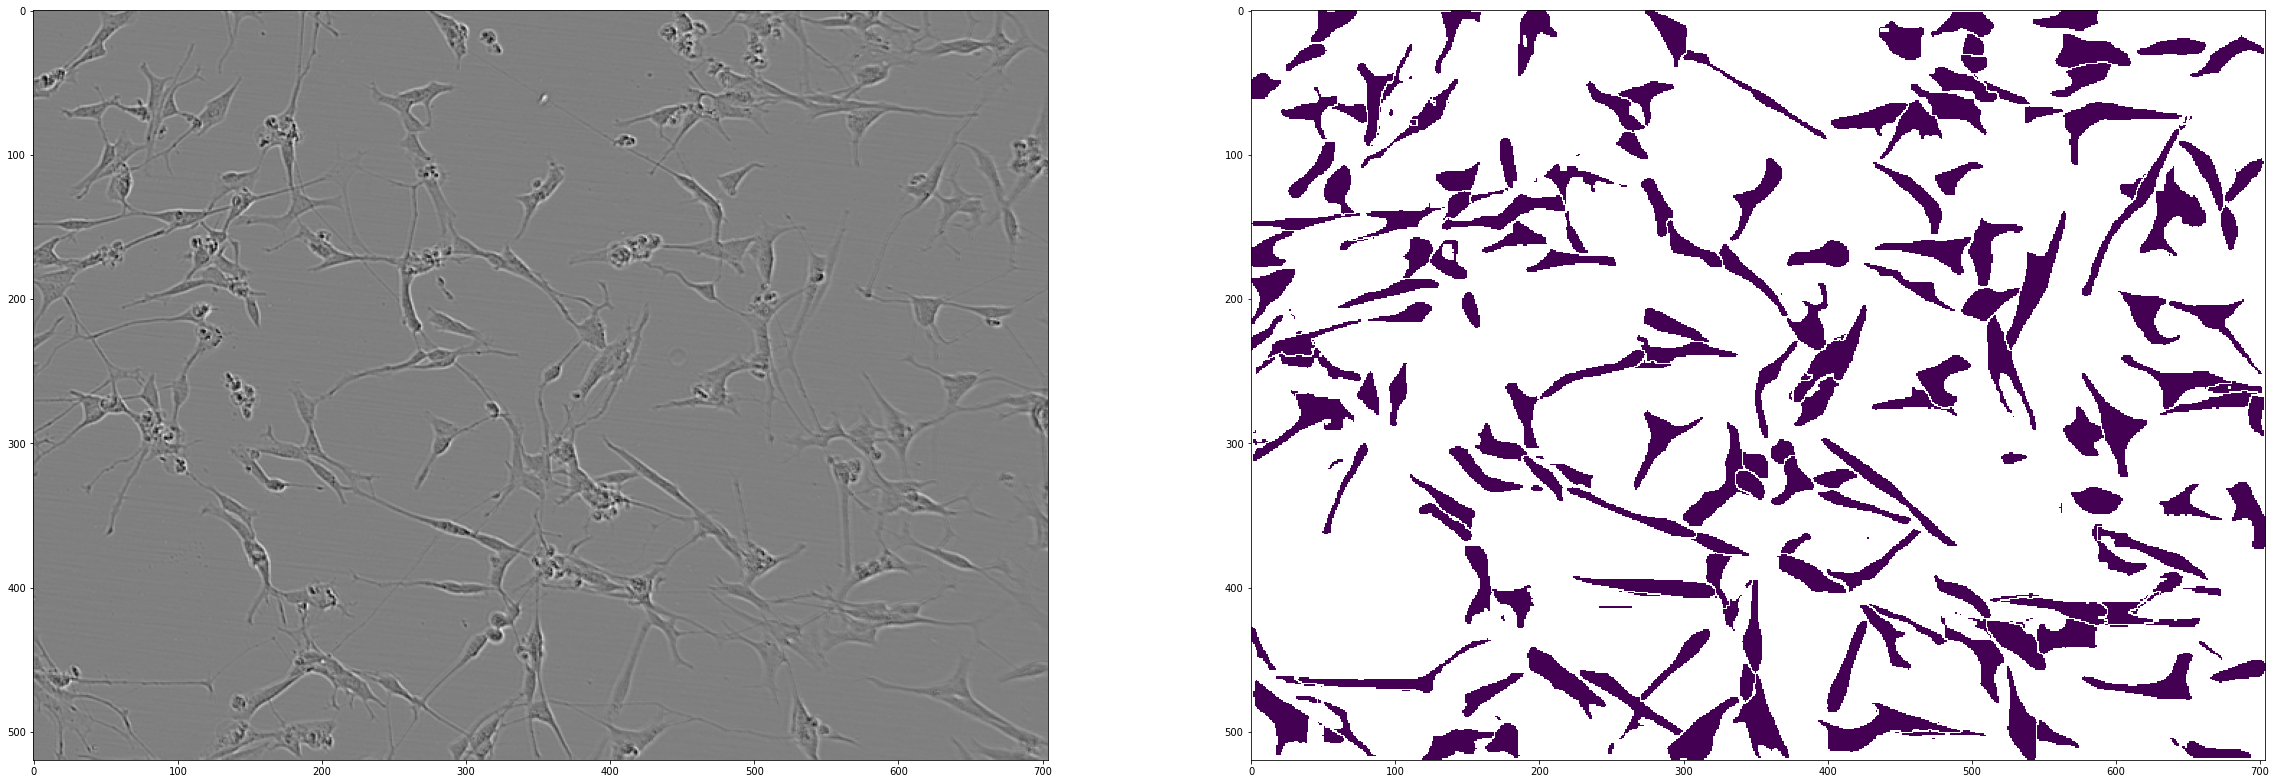

In [22]:
pred_masks, pred_class = pred_segmentation_model(cell_type_model_weights['astro'], test_file_names[0], num_classes=1)

image = cv2.imread(str(test_file_names[0]))

res = clean_masks(pred_masks, pred_class)
_, axs = plt.subplots(1,2, figsize=(40,15))
axs[0].imshow(image)
for enc in res:
    dec = rle_decode(enc)
    axs[1].imshow(np.ma.masked_where(dec==0, dec))

The image on the right shows the masks generated by our model for the image on the left.

Further, the benefits of non max suppression can be visualized by comparing the masks generated by a single model vs those generated by the ensemble.

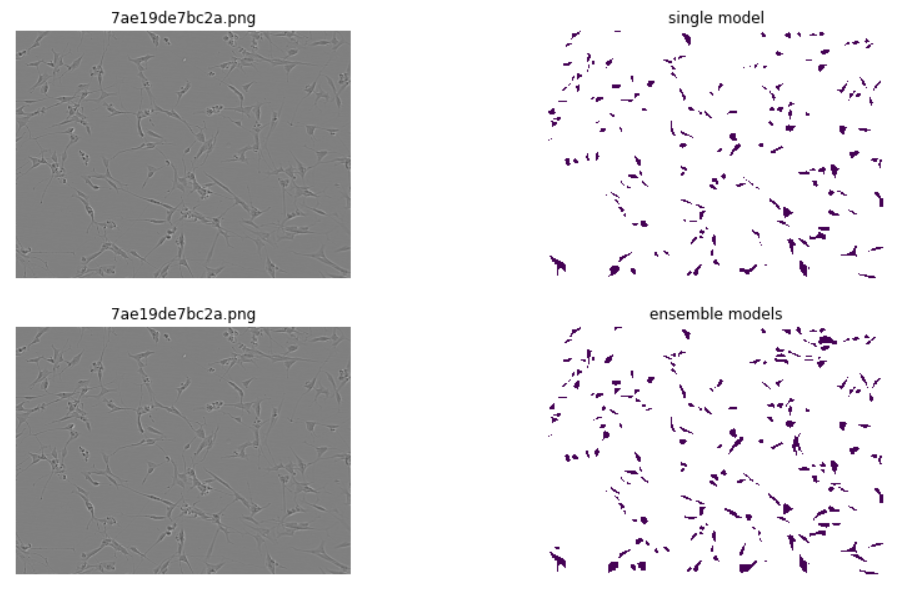

In [23]:
IPython.display.Image(filename = '../input/imgdataset/unknown-7.png')

In summary, we submitted 3 different versions of our notebook with different levels of success. They are as follows:

1. 80-20 Train-test split: 0.291
2. 5-fold data split and ensembling/NMS: 0.295
3. Class-wise inference: 0.265